In [1]:
# 📦 Installation des bibliothèques complémentaires pour ton projet
!pip install memory-profiler psutil GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=ba840374fe6d28e8675f3998201938ec647b7d6dfe7ca465a3d702867fbeeffd
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


In [2]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

# 📌 1. Définir les transformations : normalisation (valeurs recommandées pour CIFAR-10)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # ↔ retournement aléatoire
    transforms.RandomCrop(32, padding=4),     # ⤵ découpe d'image pour plus de variété
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# 📌 2. Télécharger et charger le jeu d'entraînement CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

trainloader = DataLoader(trainset,
                         batch_size=128,     # nombre d'images dans un "lot" (batch)
                         shuffle=True,       # mélanger les données à chaque époque
                         num_workers=2)      # nombre de processus pour charger les données

# 📌 3. Télécharger et charger le jeu de test CIFAR-10
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = DataLoader(testset,
                        batch_size=128,
                        shuffle=False,
                        num_workers=2)

# 📌 4. Afficher une confirmation
print(f"> CIFAR-10 chargé : {len(trainset)} images d'entraînement et {len(testset)} images de test.")


100%|██████████| 170M/170M [00:02<00:00, 84.5MB/s] 


> CIFAR-10 chargé : 50000 images d'entraînement et 10000 images de test.


In [10]:
import torch.nn as nn
import torchvision.models as models
from torch.utils.checkpoint import checkpoint_sequential

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🔧 Appareil utilisé : {device.upper()}")

class CheckpointedResNet18(nn.Module):
    def __init__(self, segments=2):
        super(CheckpointedResNet18, self).__init__()
        
        # Charger ResNet-18 pré-entraîné (on remplace seulement quelques éléments)
        base_model = models.resnet18(num_classes=10)

        # Adapter pour CIFAR-10 : petite image (32x32)
        base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        base_model.maxpool = nn.Identity()

        # Séparer en deux : 
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # Tout sauf avgpool + fc
        self.avgpool = base_model.avgpool
        self.fc = base_model.fc

        # Segments pour checkpointing
        self.segments = segments

    def forward(self, x):
        x = checkpoint_sequential(self.features, self.segments, x, use_reentrant=False)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # [batch_size, 512]
        x = self.fc(x)
        return x

def get_resnet18_with_checkpointing():
    return CheckpointedResNet18(segments=2).to(device)


🔧 Appareil utilisé : CUDA


In [11]:
# Créer le modèle avec checkpointing
model = get_resnet18_with_checkpointing()

# Vérifier la structure du modèle
print(model)

# Vérifier qu'il est bien sur GPU
print(f"Modèle sur : {next(model.parameters()).device}")


CheckpointedResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2

In [13]:
def train(model, optimizer, trainloader, epochs=5, preconditioner=None):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_history = []  # ← ici on stocke la perte moyenne par époque

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            if preconditioner is not None:
                preconditioner.step()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"📘 Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    return loss_history  # ← retourner la courbe

In [14]:
# 📌 Fonction pour tester la précision du modèle sur les données de test
def test(model, testloader):
    model.eval()  # Mode évaluation (désactive le dropout, etc.)
    correct = 0
    total = 0
    with torch.no_grad():  # Pas besoin de calculer les gradients ici
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)                # Prédiction du modèle
            _, predicted = torch.max(outputs, 1)   # Prendre la classe avec la plus grande probabilité
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"✅ Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [15]:
import torch
import torch.nn as nn
import time  # ✅ Import nécessaire

In [8]:
# ✅ Créer le modèle avec checkpointing
model = get_resnet18_with_checkpointing()

# ✅ Optimiseur Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ Ajouter un scheduler pour réduire le learning rate tous les 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ✅ Entraîner avec suivi du temps
start = time.time()

# ✔️ Version modifiée de train() AVEC scheduler
def train_with_scheduler(model, optimizer, scheduler, trainloader, epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"📘 Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(trainloader):.4f}")

train_with_scheduler(model, optimizer, scheduler, trainloader, epochs=20)

# ✅ Tester et mesurer
acc = test(model, testloader)
end = time.time()

print(f"🕒 Temps total d'entraînement : {(end - start)/60:.2f} minutes")
print(f"🎯 Précision finale : {acc:.2f}%")


📘 Epoch [1/20] - Loss: 1.3384
📘 Epoch [2/20] - Loss: 0.8693
📘 Epoch [3/20] - Loss: 0.6706
📘 Epoch [4/20] - Loss: 0.5647
📘 Epoch [5/20] - Loss: 0.4966
📘 Epoch [6/20] - Loss: 0.4391
📘 Epoch [7/20] - Loss: 0.3985
📘 Epoch [8/20] - Loss: 0.3579
📘 Epoch [9/20] - Loss: 0.3313
📘 Epoch [10/20] - Loss: 0.3066
📘 Epoch [11/20] - Loss: 0.2218
📘 Epoch [12/20] - Loss: 0.2011
📘 Epoch [13/20] - Loss: 0.1916
📘 Epoch [14/20] - Loss: 0.1729
📘 Epoch [15/20] - Loss: 0.1634
📘 Epoch [16/20] - Loss: 0.1472
📘 Epoch [17/20] - Loss: 0.1406
📘 Epoch [18/20] - Loss: 0.1332
📘 Epoch [19/20] - Loss: 0.1223
📘 Epoch [20/20] - Loss: 0.1178
✅ Test Accuracy: 89.78%
🕒 Temps total d'entraînement : 14.64 minutes
🎯 Précision finale : 89.78%


In [8]:
!pip install GPUtil

In [16]:
import psutil
import GPUtil

def get_resource_usage():
    cpu_mem = psutil.virtual_memory().used / 1024 / 1024  # en Mo
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        print(f"🧠 RAM utilisée : {cpu_mem:.2f} MB")
        print(f"🧠 GPU mémoire : {gpu.memoryUsed:.2f} MB ({gpu.memoryUtil * 100:.1f}%)")
        print(f"⚙️ GPU load : {gpu.load * 100:.1f}%")
    else:
        print("Aucun GPU détecté.")

# 💡 Appelle cette fonction après chaque test :
get_resource_usage()


🧠 RAM utilisée : 1991.91 MB
🧠 GPU mémoire : 211.00 MB (1.4%)
⚙️ GPU load : 0.0%


In [17]:
import psutil
import GPUtil

def get_memory_usage():
    ram_used = psutil.virtual_memory().used / 1024 / 1024  # RAM en Mo
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu = gpus[0]
        return ram_used, gpu.memoryUsed, gpu.load * 100  # RAM, mémoire GPU, charge GPU (%)
    else:
        return ram_used, 0.0, 0.0  # Si aucun GPU détecté


In [18]:
# 🔒 Fonction pour fixer la seed aléatoire
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seeds = [13, 88, 271]


In [19]:
import matplotlib.pyplot as plt


🔁 SGD avec seed = 13
📘 Epoch [1/20] - Loss: 1.5821
📘 Epoch [2/20] - Loss: 1.1113
📘 Epoch [3/20] - Loss: 0.8778
📘 Epoch [4/20] - Loss: 0.7393
📘 Epoch [5/20] - Loss: 0.6330
📘 Epoch [6/20] - Loss: 0.5655
📘 Epoch [7/20] - Loss: 0.5140
📘 Epoch [8/20] - Loss: 0.4669
📘 Epoch [9/20] - Loss: 0.4287
📘 Epoch [10/20] - Loss: 0.3988
📘 Epoch [11/20] - Loss: 0.3710
📘 Epoch [12/20] - Loss: 0.3428
📘 Epoch [13/20] - Loss: 0.3192
📘 Epoch [14/20] - Loss: 0.3020
📘 Epoch [15/20] - Loss: 0.2859
📘 Epoch [16/20] - Loss: 0.2639
📘 Epoch [17/20] - Loss: 0.2474
📘 Epoch [18/20] - Loss: 0.2376
📘 Epoch [19/20] - Loss: 0.2242
📘 Epoch [20/20] - Loss: 0.2130


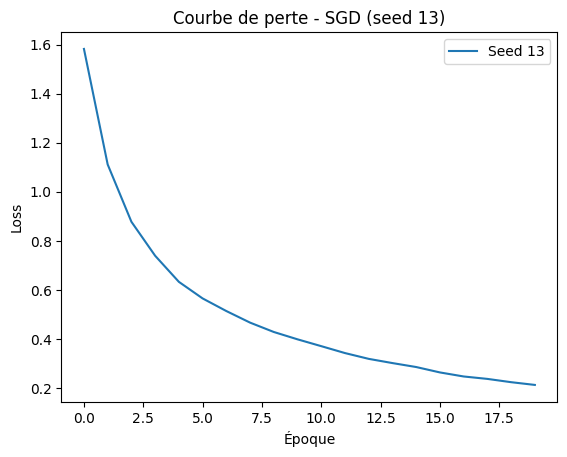

✅ Test Accuracy: 86.48%
📉 SGD - Précision : 86.48%
🕒 Temps total : 18.12 minutes
🧠 RAM utilisée : 2237.38 MB
🧠 GPU mémoire : 1173.00 MB (7.6%)
⚙️ GPU load : 63.0%

🔁 SGD avec seed = 88
📘 Epoch [1/20] - Loss: 1.5679
📘 Epoch [2/20] - Loss: 1.0836
📘 Epoch [3/20] - Loss: 0.8675
📘 Epoch [4/20] - Loss: 0.7192
📘 Epoch [5/20] - Loss: 0.6228
📘 Epoch [6/20] - Loss: 0.5589
📘 Epoch [7/20] - Loss: 0.5103
📘 Epoch [8/20] - Loss: 0.4664
📘 Epoch [9/20] - Loss: 0.4274
📘 Epoch [10/20] - Loss: 0.3963
📘 Epoch [11/20] - Loss: 0.3764
📘 Epoch [12/20] - Loss: 0.3449
📘 Epoch [13/20] - Loss: 0.3236
📘 Epoch [14/20] - Loss: 0.3058
📘 Epoch [15/20] - Loss: 0.2909
📘 Epoch [16/20] - Loss: 0.2697
📘 Epoch [17/20] - Loss: 0.2542
📘 Epoch [18/20] - Loss: 0.2391
📘 Epoch [19/20] - Loss: 0.2320
📘 Epoch [20/20] - Loss: 0.2131


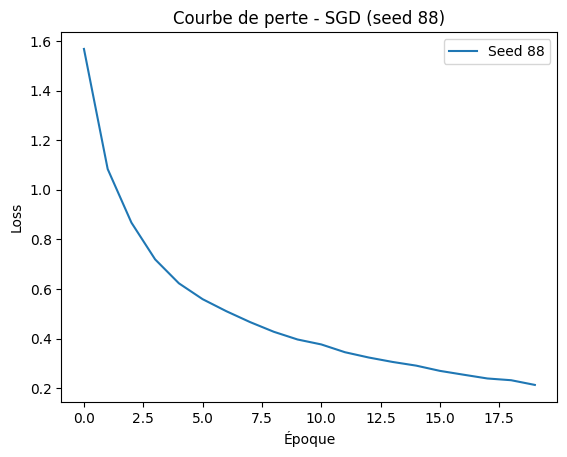

✅ Test Accuracy: 87.31%
📉 SGD - Précision : 87.31%
🕒 Temps total : 18.18 minutes
🧠 RAM utilisée : 2307.66 MB
🧠 GPU mémoire : 1175.00 MB (7.6%)
⚙️ GPU load : 92.0%

🔁 SGD avec seed = 271
📘 Epoch [1/20] - Loss: 1.5595
📘 Epoch [2/20] - Loss: 1.0948
📘 Epoch [3/20] - Loss: 0.8603
📘 Epoch [4/20] - Loss: 0.7136
📘 Epoch [5/20] - Loss: 0.6225
📘 Epoch [6/20] - Loss: 0.5562
📘 Epoch [7/20] - Loss: 0.5076
📘 Epoch [8/20] - Loss: 0.4659
📘 Epoch [9/20] - Loss: 0.4277
📘 Epoch [10/20] - Loss: 0.3926
📘 Epoch [11/20] - Loss: 0.3673
📘 Epoch [12/20] - Loss: 0.3427
📘 Epoch [13/20] - Loss: 0.3199
📘 Epoch [14/20] - Loss: 0.3039
📘 Epoch [15/20] - Loss: 0.2823
📘 Epoch [16/20] - Loss: 0.2726
📘 Epoch [17/20] - Loss: 0.2553
📘 Epoch [18/20] - Loss: 0.2348
📘 Epoch [19/20] - Loss: 0.2274
📘 Epoch [20/20] - Loss: 0.2117


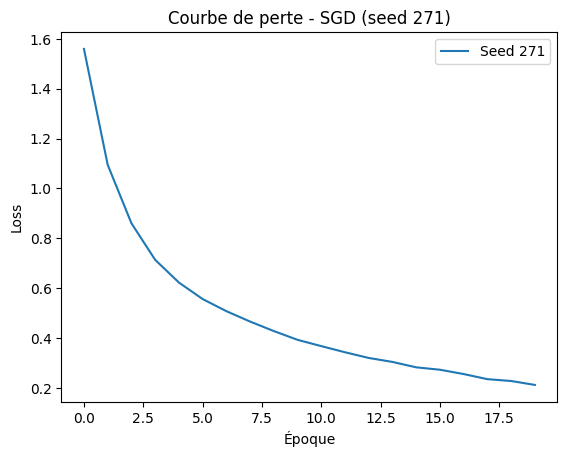

✅ Test Accuracy: 86.51%
📉 SGD - Précision : 86.51%
🕒 Temps total : 18.18 minutes
🧠 RAM utilisée : 2356.44 MB
🧠 GPU mémoire : 1175.00 MB (7.6%)
⚙️ GPU load : 92.0%


In [20]:
sgd_stabilities = []  # pour stocker les écarts-types de perte (σ)

for seed in seeds:
    print(f"\n🔁 SGD avec seed = {seed}")
    set_seed(seed)  # Fixer la graine

    model_sgd = get_resnet18_with_checkpointing()
    optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

    start_sgd = time.time()
    losses_sgd = train(model_sgd, optimizer_sgd, trainloader, epochs=20)

    plt.plot(losses_sgd, label=f"Seed {seed}")
    plt.title(f"Courbe de perte - SGD (seed {seed})")
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc_sgd = test(model_sgd, testloader)
    ram_sgd, gpu_sgd, load_sgd = get_memory_usage()
    std_sgd = np.std(losses_sgd)
    sgd_stabilities.append(std_sgd)
    end_sgd = time.time()

    print(f"📉 SGD - Précision : {acc_sgd:.2f}%")
    print(f"🕒 Temps total : {(end_sgd - start_sgd)/60:.2f} minutes")
    get_resource_usage()



🔁 Adam avec seed = 13
📘 Epoch [1/20] - Loss: 1.3730
📘 Epoch [2/20] - Loss: 0.9144
📘 Epoch [3/20] - Loss: 0.7161
📘 Epoch [4/20] - Loss: 0.5882
📘 Epoch [5/20] - Loss: 0.5174
📘 Epoch [6/20] - Loss: 0.4533
📘 Epoch [7/20] - Loss: 0.4075
📘 Epoch [8/20] - Loss: 0.3713
📘 Epoch [9/20] - Loss: 0.3376
📘 Epoch [10/20] - Loss: 0.3083
📘 Epoch [11/20] - Loss: 0.2845
📘 Epoch [12/20] - Loss: 0.2636
📘 Epoch [13/20] - Loss: 0.2427
📘 Epoch [14/20] - Loss: 0.2251
📘 Epoch [15/20] - Loss: 0.2146
📘 Epoch [16/20] - Loss: 0.1930
📘 Epoch [17/20] - Loss: 0.1811
📘 Epoch [18/20] - Loss: 0.1711
📘 Epoch [19/20] - Loss: 0.1563
📘 Epoch [20/20] - Loss: 0.1442


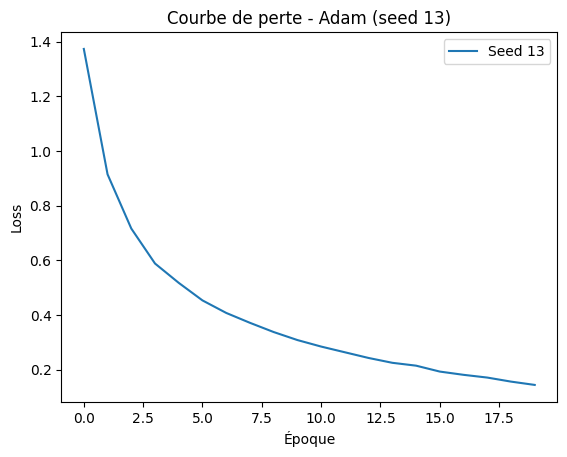

✅ Test Accuracy: 89.18%
📈 Adam - Précision : 89.18%
🕒 Temps total : 18.45 minutes
🧠 RAM utilisée : 2417.18 MB
🧠 GPU mémoire : 1425.00 MB (9.3%)
⚙️ GPU load : 59.0%

🔁 Adam avec seed = 88
📘 Epoch [1/20] - Loss: 1.3396
📘 Epoch [2/20] - Loss: 0.8500
📘 Epoch [3/20] - Loss: 0.6692
📘 Epoch [4/20] - Loss: 0.5599
📘 Epoch [5/20] - Loss: 0.4881
📘 Epoch [6/20] - Loss: 0.4394
📘 Epoch [7/20] - Loss: 0.3955
📘 Epoch [8/20] - Loss: 0.3614
📘 Epoch [9/20] - Loss: 0.3274
📘 Epoch [10/20] - Loss: 0.3011
📘 Epoch [11/20] - Loss: 0.2814
📘 Epoch [12/20] - Loss: 0.2551
📘 Epoch [13/20] - Loss: 0.2428
📘 Epoch [14/20] - Loss: 0.2226
📘 Epoch [15/20] - Loss: 0.2133
📘 Epoch [16/20] - Loss: 0.1923
📘 Epoch [17/20] - Loss: 0.1795
📘 Epoch [18/20] - Loss: 0.1692
📘 Epoch [19/20] - Loss: 0.1618
📘 Epoch [20/20] - Loss: 0.1434


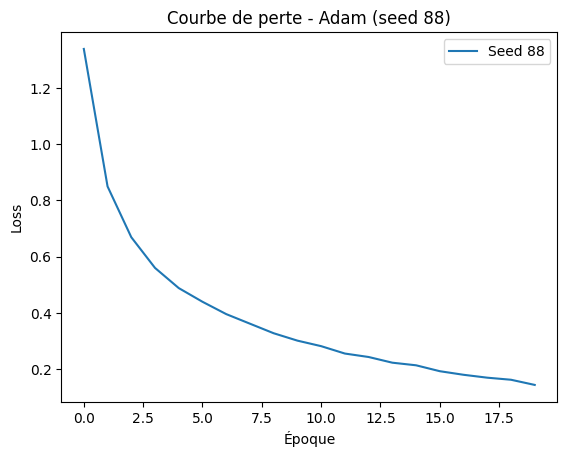

✅ Test Accuracy: 89.90%
📈 Adam - Précision : 89.90%
🕒 Temps total : 18.49 minutes
🧠 RAM utilisée : 2483.48 MB
🧠 GPU mémoire : 1427.00 MB (9.3%)
⚙️ GPU load : 62.0%

🔁 Adam avec seed = 271
📘 Epoch [1/20] - Loss: 1.3291
📘 Epoch [2/20] - Loss: 0.8390
📘 Epoch [3/20] - Loss: 0.6635
📘 Epoch [4/20] - Loss: 0.5575
📘 Epoch [5/20] - Loss: 0.4914
📘 Epoch [6/20] - Loss: 0.4372
📘 Epoch [7/20] - Loss: 0.3902
📘 Epoch [8/20] - Loss: 0.3613
📘 Epoch [9/20] - Loss: 0.3252
📘 Epoch [10/20] - Loss: 0.3022
📘 Epoch [11/20] - Loss: 0.2737
📘 Epoch [12/20] - Loss: 0.2559
📘 Epoch [13/20] - Loss: 0.2360
📘 Epoch [14/20] - Loss: 0.2190
📘 Epoch [15/20] - Loss: 0.2076
📘 Epoch [16/20] - Loss: 0.1915
📘 Epoch [17/20] - Loss: 0.1778
📘 Epoch [18/20] - Loss: 0.1644
📘 Epoch [19/20] - Loss: 0.1534
📘 Epoch [20/20] - Loss: 0.1460


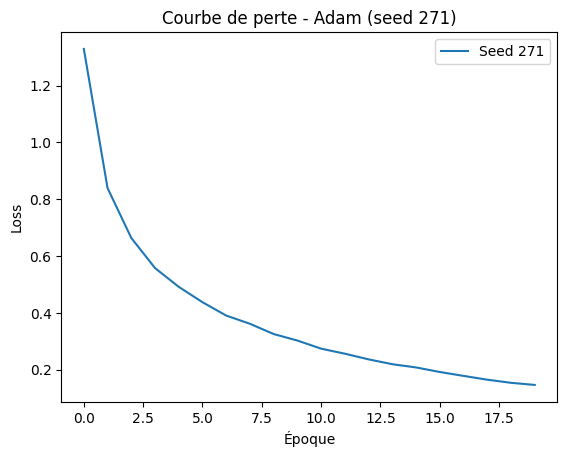

✅ Test Accuracy: 89.65%
📈 Adam - Précision : 89.65%
🕒 Temps total : 18.51 minutes
🧠 RAM utilisée : 2460.66 MB
🧠 GPU mémoire : 1427.00 MB (9.3%)
⚙️ GPU load : 94.0%


In [21]:
adam_stabilities = [] 
for seed in seeds:
    print(f"\n🔁 Adam avec seed = {seed}")
    set_seed(seed)

    model_adam = get_resnet18_with_checkpointing()
    optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

    start_adam = time.time()
    losses_adam = train(model_adam, optimizer_adam, trainloader, epochs=20)

    plt.plot(losses_adam, label=f"Seed {seed}")
    plt.title(f"Courbe de perte - Adam (seed {seed})")
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc_adam = test(model_adam, testloader)
    ram_adam, gpu_adam, load_adam = get_memory_usage()
    std_adam = np.std(losses_adam)
    adam_stabilities.append(std_adam)
    end_adam = time.time()

    print(f"📈 Adam - Précision : {acc_adam:.2f}%")
    print(f"🕒 Temps total : {(end_adam - start_adam)/60:.2f} minutes")
    get_resource_usage()


Cloning into 'shampoo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 20.15 KiB | 825.00 KiB/s, done.
Resolving deltas: 100% (1/1), done.

🔁 Shampoo avec seed = 13
📘 Epoch [1/20] - Loss: 1.9046
📘 Epoch [2/20] - Loss: 1.5639
📘 Epoch [3/20] - Loss: 1.3914
📘 Epoch [4/20] - Loss: 1.2584
📘 Epoch [5/20] - Loss: 1.1399
📘 Epoch [6/20] - Loss: 1.0381
📘 Epoch [7/20] - Loss: 0.9550
📘 Epoch [8/20] - Loss: 0.8865
📘 Epoch [9/20] - Loss: 0.8247
📘 Epoch [10/20] - Loss: 0.7737
📘 Epoch [11/20] - Loss: 0.7256
📘 Epoch [12/20] - Loss: 0.6741
📘 Epoch [13/20] - Loss: 0.6321
📘 Epoch [14/20] - Loss: 0.5957
📘 Epoch [15/20] - Loss: 0.5605
📘 Epoch [16/20] - Loss: 0.5289
📘 Epoch [17/20] - Loss: 0.5013
📘 Epoch [18/20] - Loss: 0.4804
📘 Epoch [19/20] - Loss: 0.4563
📘 Epoch [20/20] - Loss: 0.4336


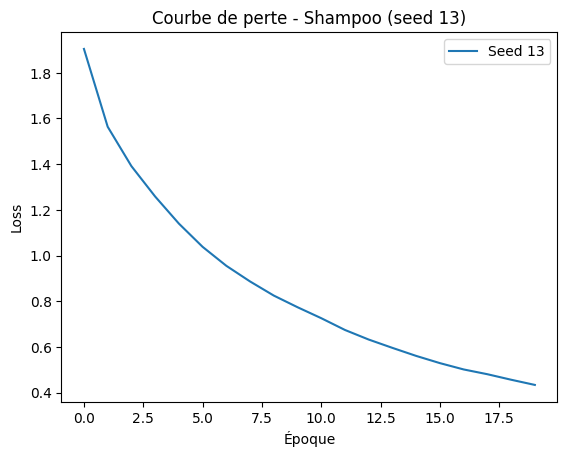

✅ Test Accuracy: 82.17%
🧴 Shampoo (optimisé) - Précision : 82.17%
🕒 Temps total : 50.74 minutes
🧠 RAM utilisée : 2610.15 MB
🧠 GPU mémoire : 1739.00 MB (11.3%)
⚙️ GPU load : 92.0%

🔁 Shampoo avec seed = 88
📘 Epoch [1/20] - Loss: 1.9091
📘 Epoch [2/20] - Loss: 1.5279
📘 Epoch [3/20] - Loss: 1.3457
📘 Epoch [4/20] - Loss: 1.1960
📘 Epoch [5/20] - Loss: 1.0783
📘 Epoch [6/20] - Loss: 0.9861
📘 Epoch [7/20] - Loss: 0.9125
📘 Epoch [8/20] - Loss: 0.8454
📘 Epoch [9/20] - Loss: 0.7894
📘 Epoch [10/20] - Loss: 0.7302
📘 Epoch [11/20] - Loss: 0.6850
📘 Epoch [12/20] - Loss: 0.6385
📘 Epoch [13/20] - Loss: 0.5989
📘 Epoch [14/20] - Loss: 0.5682
📘 Epoch [15/20] - Loss: 0.5380
📘 Epoch [16/20] - Loss: 0.5095
📘 Epoch [17/20] - Loss: 0.4881
📘 Epoch [18/20] - Loss: 0.4624
📘 Epoch [19/20] - Loss: 0.4436
📘 Epoch [20/20] - Loss: 0.4284


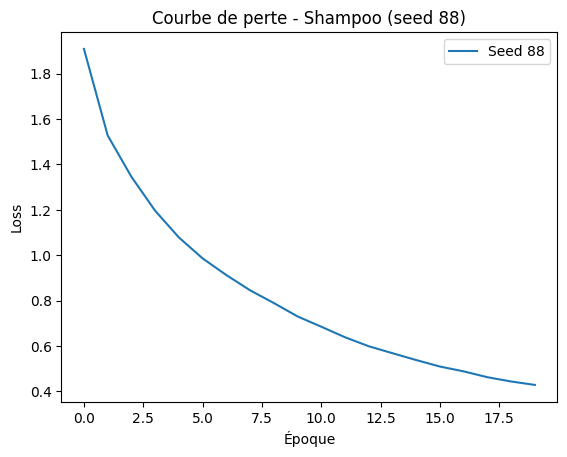

✅ Test Accuracy: 81.88%
🧴 Shampoo (optimisé) - Précision : 81.88%
🕒 Temps total : 50.71 minutes
🧠 RAM utilisée : 2636.19 MB
🧠 GPU mémoire : 1739.00 MB (11.3%)
⚙️ GPU load : 90.0%

🔁 Shampoo avec seed = 271
📘 Epoch [1/20] - Loss: 1.9100
📘 Epoch [2/20] - Loss: 1.5296
📘 Epoch [3/20] - Loss: 1.3527
📘 Epoch [4/20] - Loss: 1.2244
📘 Epoch [5/20] - Loss: 1.1123
📘 Epoch [6/20] - Loss: 1.0106
📘 Epoch [7/20] - Loss: 0.9258
📘 Epoch [8/20] - Loss: 0.8499
📘 Epoch [9/20] - Loss: 0.7831
📘 Epoch [10/20] - Loss: 0.7264
📘 Epoch [11/20] - Loss: 0.6774
📘 Epoch [12/20] - Loss: 0.6298
📘 Epoch [13/20] - Loss: 0.5944
📘 Epoch [14/20] - Loss: 0.5601
📘 Epoch [15/20] - Loss: 0.5313
📘 Epoch [16/20] - Loss: 0.5061
📘 Epoch [17/20] - Loss: 0.4811
📘 Epoch [18/20] - Loss: 0.4604
📘 Epoch [19/20] - Loss: 0.4394
📘 Epoch [20/20] - Loss: 0.4227


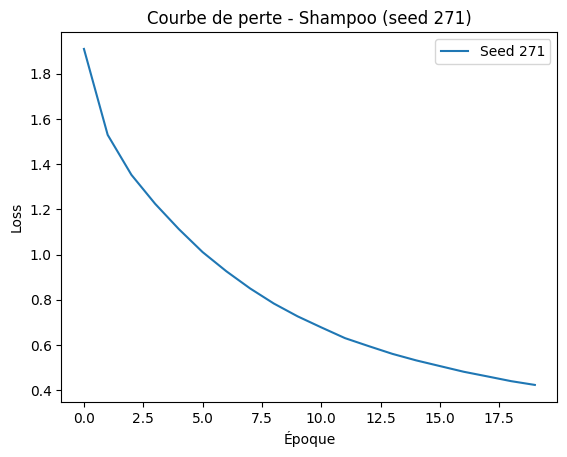

✅ Test Accuracy: 80.81%
🧴 Shampoo (optimisé) - Précision : 80.81%
🕒 Temps total : 49.09 minutes
🧠 RAM utilisée : 2669.05 MB
🧠 GPU mémoire : 1739.00 MB (11.3%)
⚙️ GPU load : 92.0%


In [23]:
shampoo_stabilities = []
!rm -rf shampoo  
!git clone https://github.com/SalmaSalama/shampoo.git
import sys
sys.path.append('/kaggle/working/shampoo/Shampoo')  

from shampoo_optimizer import Shampoo, ShampooHyperParams


for seed in seeds:
    print(f"\n🔁 Shampoo avec seed = {seed}")
    set_seed(seed)
    hps = ShampooHyperParams(
        block_size=64,
        statistics_compute_steps=10,
        preconditioning_compute_steps=20,
        weight_decay=0.01,
        nesterov=True
    )

    model_shampoo = get_resnet18_with_checkpointing()
    optimizer_shampoo = Shampoo(model_shampoo.parameters(), lr=0.001, momentum=0.9, hyperparams=hps)

    start_shampoo = time.time()
    losses_shampoo = train(model_shampoo, optimizer_shampoo, trainloader, epochs=20)

    plt.plot(losses_shampoo, label=f"Seed {seed}")
    plt.title(f"Courbe de perte - Shampoo (seed {seed})")
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc_shampoo = test(model_shampoo, testloader)
    ram_shampoo, gpu_shampoo, load_shampoo = get_memory_usage()
    std_shampoo = np.std(losses_shampoo)
    shampoo_stabilities.append(std_shampoo)
    end_shampoo = time.time()

    print(f"🧴 Shampoo (optimisé) - Précision : {acc_shampoo:.2f}%")
    print(f"🕒 Temps total : {(end_shampoo - start_shampoo)/60:.2f} minutes")
    get_resource_usage()


In [24]:
!rm -rf kfac-pytorch


In [25]:
!git clone https://github.com/gpauloski/kfac-pytorch.git

Cloning into 'kfac-pytorch'...
remote: Enumerating objects: 3526, done.
remote: Counting objects: 100% (786/786), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 3526 (delta 703), reused 656 (delta 656), pack-reused 2740 (from 2)
Receiving objects: 100% (3526/3526), 1010.81 KiB | 9.63 MiB/s, done.
Resolving deltas: 100% (2317/2317), done.


In [26]:
import sys
sys.path.append('/kaggle/working/kfac-pytorch')

In [27]:
file_path = "/kaggle/working/kfac-pytorch/kfac/__init__.py"

# Charger le contenu
with open(file_path, "r") as f:
    lines = f.readlines()

# Commenter la ligne qui contient importlib_metadata.version
with open(file_path, "w") as f:
    for line in lines:
        if "importlib_metadata.version" in line:
            f.write("# " + line)  # commenter
        else:
            f.write(line)

print("✅ Ligne __version__ désactivée avec succès !")


✅ Ligne __version__ désactivée avec succès !



🔁 K-FAC avec seed = 13


/kaggle/working/kfac-pytorch/kfac/base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


📘 Epoch [1/20] - Loss: 1.5488
📘 Epoch [2/20] - Loss: 1.2545
📘 Epoch [3/20] - Loss: 1.3524
📘 Epoch [4/20] - Loss: 1.2975
📘 Epoch [5/20] - Loss: 1.1263
📘 Epoch [6/20] - Loss: 0.9721
📘 Epoch [7/20] - Loss: 0.7882
📘 Epoch [8/20] - Loss: 0.6739
📘 Epoch [9/20] - Loss: 0.5761
📘 Epoch [10/20] - Loss: 0.5259
📘 Epoch [11/20] - Loss: 0.4714
📘 Epoch [12/20] - Loss: 0.4263
📘 Epoch [13/20] - Loss: 0.4000
📘 Epoch [14/20] - Loss: 0.3564
📘 Epoch [15/20] - Loss: 0.3527
📘 Epoch [16/20] - Loss: 0.3226
📘 Epoch [17/20] - Loss: 0.3252
📘 Epoch [18/20] - Loss: 0.2781
📘 Epoch [19/20] - Loss: 0.2585
📘 Epoch [20/20] - Loss: 0.2360


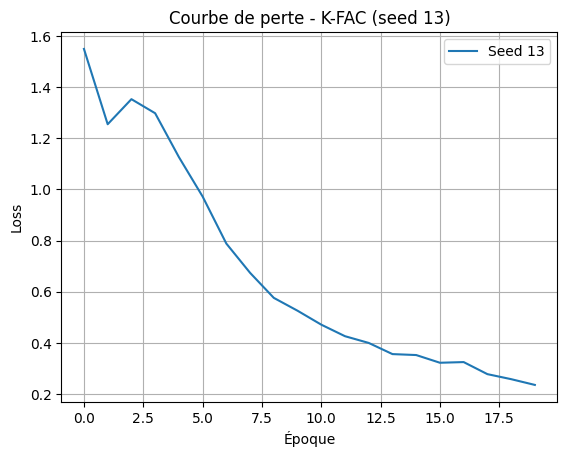

✅ Test Accuracy: 87.57%
📊 K-FAC - Précision : 87.57%
🕒 Temps total : 33.73 minutes
🧠 RAM utilisée : 2661.70 MB
🧠 GPU mémoire : 3559.00 MB (23.2%)
⚙️ GPU load : 71.0%

🔁 K-FAC avec seed = 88
📘 Epoch [1/20] - Loss: 1.5329
📘 Epoch [2/20] - Loss: 1.2198
📘 Epoch [3/20] - Loss: 1.3375
📘 Epoch [4/20] - Loss: 1.2850
📘 Epoch [5/20] - Loss: 1.0997
📘 Epoch [6/20] - Loss: 0.9638
📘 Epoch [7/20] - Loss: 0.8106
📘 Epoch [8/20] - Loss: 0.6720
📘 Epoch [9/20] - Loss: 0.5893
📘 Epoch [10/20] - Loss: 0.5407
📘 Epoch [11/20] - Loss: 0.4719
📘 Epoch [12/20] - Loss: 0.4024
📘 Epoch [13/20] - Loss: 0.3798
📘 Epoch [14/20] - Loss: 0.3621
📘 Epoch [15/20] - Loss: 0.3475
📘 Epoch [16/20] - Loss: 0.3361
📘 Epoch [17/20] - Loss: 0.3094
📘 Epoch [18/20] - Loss: 0.2754
📘 Epoch [19/20] - Loss: 0.2645
📘 Epoch [20/20] - Loss: 0.2404


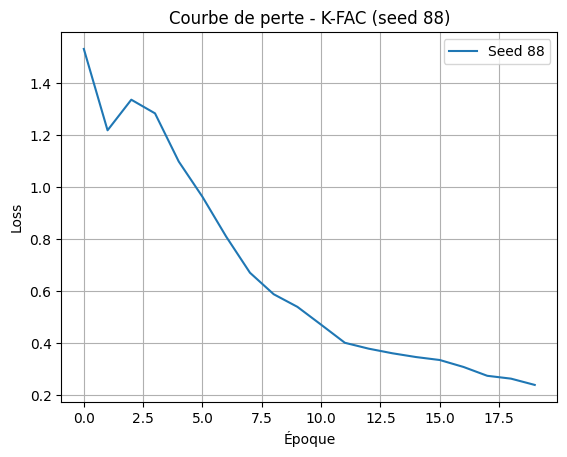

✅ Test Accuracy: 87.93%
📊 K-FAC - Précision : 87.93%
🕒 Temps total : 33.69 minutes
🧠 RAM utilisée : 2708.25 MB
🧠 GPU mémoire : 4443.00 MB (28.9%)
⚙️ GPU load : 92.0%

🔁 K-FAC avec seed = 271
📘 Epoch [1/20] - Loss: 1.5424
📘 Epoch [2/20] - Loss: 1.2379
📘 Epoch [3/20] - Loss: 1.3182
📘 Epoch [4/20] - Loss: 1.1660
📘 Epoch [5/20] - Loss: 0.9421
📘 Epoch [6/20] - Loss: 0.7659
📘 Epoch [7/20] - Loss: 0.6473
📘 Epoch [8/20] - Loss: 0.5838
📘 Epoch [9/20] - Loss: 0.4985
📘 Epoch [10/20] - Loss: 0.4626
📘 Epoch [11/20] - Loss: 0.4177
📘 Epoch [12/20] - Loss: 0.3892
📘 Epoch [13/20] - Loss: 0.3631
📘 Epoch [14/20] - Loss: 0.3433
📘 Epoch [15/20] - Loss: 0.3209
📘 Epoch [16/20] - Loss: 0.2922
📘 Epoch [17/20] - Loss: 0.2838
📘 Epoch [18/20] - Loss: 0.2696
📘 Epoch [19/20] - Loss: 0.2586
📘 Epoch [20/20] - Loss: 0.2334


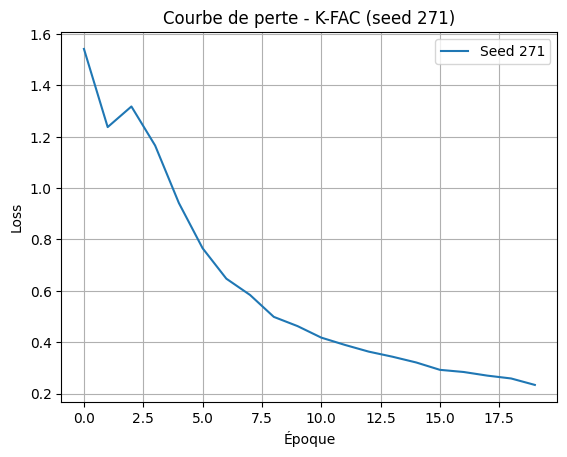

✅ Test Accuracy: 87.67%
📊 K-FAC - Précision : 87.67%
🕒 Temps total : 33.69 minutes
🧠 RAM utilisée : 2739.64 MB
🧠 GPU mémoire : 5329.00 MB (34.7%)
⚙️ GPU load : 92.0%


In [28]:
from kfac.preconditioner import KFACPreconditioner
import torch.optim as optim
import matplotlib.pyplot as plt


kfac_stabilities = []

for seed in seeds:
    print(f"\n🔁 K-FAC avec seed = {seed}")
    set_seed(seed)

    # 🧠 1. Créer le modèle avec gradient checkpointing
    model_kfac = get_resnet18_with_checkpointing()

    # 🧪 2. Optimiseur de base (SGD requis par K-FAC)
    base_optimizer = optim.SGD(model_kfac.parameters(), lr=0.01, momentum=0.9)

    # ⚙️ 3. Préconditionneur K-FAC
    optimizer_kfac = KFACPreconditioner(
        model_kfac,
        factor_update_steps=10,
        inv_update_steps=10,
        damping=0.01,
        factor_decay=0.95,
        kl_clip=0.001,
        lr=0.005,
        assignment_strategy='MEMORY',
        compute_method='INVERSE',
        colocate_factors=True,
        allreduce_bucket_cap_mb=0,
        grad_worker_fraction=1.0,
        update_factors_in_hook=True,
        symmetry_aware=False,
        loglevel=40
    )

    # 🚀 4. Entraînement
    start_kfac = time.time()
    losses_kfac = train(
        model_kfac,
        base_optimizer,
        trainloader,
        epochs=20,
        preconditioner=optimizer_kfac
    )
    end_kfac = time.time()

    # 📉 5. Afficher la courbe
    plt.plot(losses_kfac, label=f"Seed {seed}")
    plt.title(f"Courbe de perte - K-FAC (seed {seed})")
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ✅ 6. Résultats
    acc_kfac = test(model_kfac, testloader)
    ram_kfac, gpu_kfac, load_kfac = get_memory_usage()
    std_kfac = np.std(losses_kfac)
    kfac_stabilities.append(std_kfac)

    print(f"📊 K-FAC - Précision : {acc_kfac:.2f}%")
    print(f"🕒 Temps total : {(end_kfac - start_kfac)/60:.2f} minutes")
    get_resource_usage()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


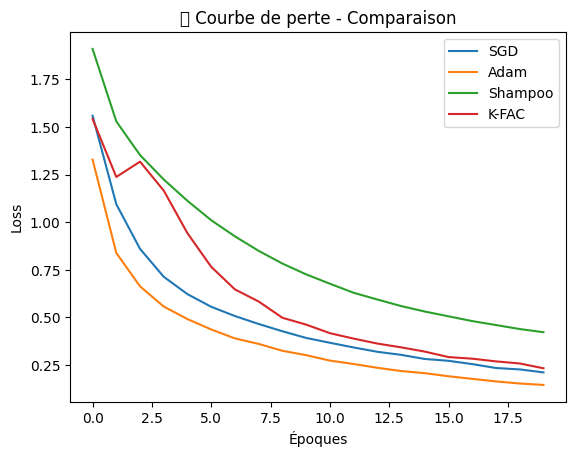

In [29]:
plt.plot(losses_sgd, label="SGD")
plt.plot(losses_adam, label="Adam")
plt.plot(losses_shampoo, label="Shampoo")
plt.plot(losses_kfac, label="K-FAC")
plt.title("📉 Courbe de perte - Comparaison")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
import pandas as pd
import numpy as np

df_stab = pd.DataFrame({
    "Optimiseur": ["SGD", "Adam", "Shampoo", "K-FAC"],
    "Stabilité σ (moyenne)": [
        np.mean(sgd_stabilities),
        np.mean(adam_stabilities),
        np.mean(shampoo_stabilities),
        np.mean(kfac_stabilities)
    ]
})

print("📊 Tableau comparatif de la stabilité (σ) sur 2 seeds :")
display(df_stab)


📊 Tableau comparatif de la stabilité (σ) sur 2 seeds :


,Optimiseur,Stabilité σ (moyenne)
0,SGD,0.333231
1,Adam,0.287039
2,Shampoo,0.396098
3,K-FAC,0.406042


In [31]:
import pandas as pd

# Résultats moyens sur 3 seeds pour chaque optimiseur
results = pd.DataFrame({
    "Optimizer": ["SGD", "Adam", "Shampoo", "K-FAC"],
    "Accuracy (%)": [86.77, 89.58, 81.62, 87.72],
    "Training Time (min)": [18.16, 18.48, 50.18, 33.70],
    "Stability σ": [0.333231, 0.287039, 0.396098, 0.406042],
    "GPU Mem (MB)": [1174.3, 1426.3, 1739.0, 4443.7],
    "GPU Load (%)": [82.3, 71.7, 91.3, 85.0],
    "RAM (MB)": [2300.49, 2453.77, 2638.46, 2703.20]
})

# Affichage
print("📊 Résultats moyens sur 3 seeds :")
display(results)


📊 Résultats moyens sur 3 seeds :


,Optimizer,Accuracy (%),Training Time (min),Stability σ,GPU Mem (MB),GPU Load (%),RAM (MB)
0,SGD,86.77,18.16,0.333231,1174.3,82.3,2300.49
1,Adam,89.58,18.48,0.287039,1426.3,71.7,2453.77
2,Shampoo,81.62,50.18,0.396098,1739.0,91.3,2638.46
3,K-FAC,87.72,33.70,0.406042,4443.7,85.0,2703.20


In [33]:
import pandas as pd

# ⚖️ Tableau forces/faiblesses
conclusion_table = pd.DataFrame({
    "Optimizer": ["SGD", "Adam", "Shampoo", "K-FAC"],
    "Forces": [
        "Simple, stable, low memory usage",
        "Fast convergence, high accuracy",
        "Handles curvature, useful for deep nets",
        "Second-order info, good for complex architectures"
    ],
    "Weaknesses": [
        "Slower convergence",
        "Higher memory than SGD",
        "Very long training, unstable",
        "Complex to tune, very high memory"
    ]
})

print("📊 Optimizer comparison – Strengths and Weaknesses:")
display(conclusion_table)


📊 Optimizer comparison – Strengths and Weaknesses:


,Optimizer,Forces,Weaknesses
0,SGD,"Simple, stable, low memory usage",Slower convergence
1,Adam,"Fast convergence, high accuracy",Higher memory than SGD
2,Shampoo,"Handles curvature, useful for deep nets","Very long training, unstable"
3,K-FAC,"Second-order info, good for complex architectures","Complex to tune, very high memory"


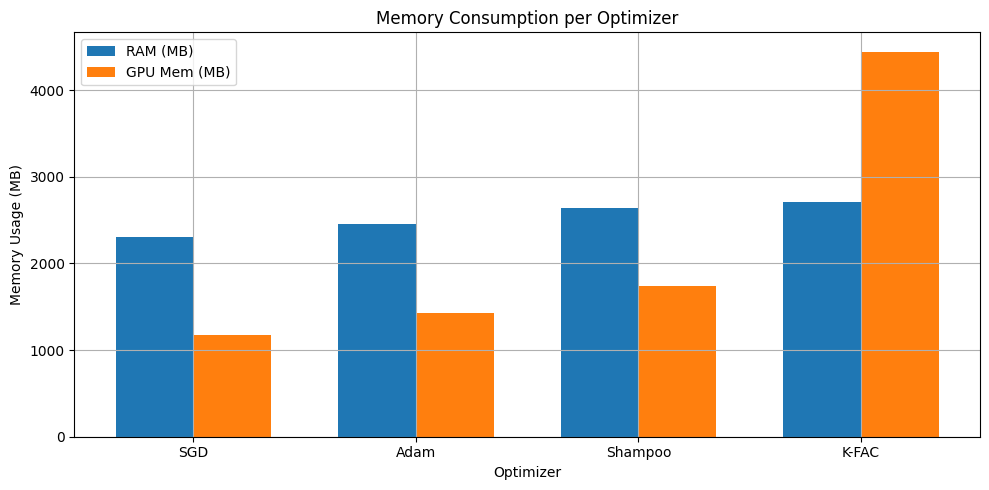

In [34]:
import matplotlib.pyplot as plt

bar_width = 0.35
index = range(len(results))

plt.figure(figsize=(10, 5))
plt.bar(index, results["RAM (MB)"], bar_width, label="RAM (MB)")
plt.bar([i + bar_width for i in index], results["GPU Mem (MB)"], bar_width, label="GPU Mem (MB)")

plt.xlabel("Optimizer")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Consumption per Optimizer")
plt.xticks([i + bar_width / 2 for i in index], results["Optimizer"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
